# Protein Expression Classification in Mice

## 1. Introduction
This project aims to classify mice into eight groups based on protein expression
measured in the nuclear fraction of the cortex. Groups are defined by genotype,
behavioral condition, and treatment.

The main objective is to build and evaluate a fully connected neural network
for multiclass classification.

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set plot style
sns.set_style("whitegrid")

# Set a random seed for reproducibility
np.random.seed(42)


## 2. Load Data
The dataset consists of two files:  
- **data3.csv** → protein expression levels (1080 samples × 72 proteins + sample ID).  
- **class3.csv** → class labels (8 possible categories).  

The first column in `data3.csv` corresponds to the sample ID and will be removed.  
The file `class3.csv` has a header row that will be skipped.

In [77]:
# Load protein expression data (removing the sample ID column)
data = pd.read_csv("../data/data3.csv", index_col=0)

# Load class labels (skip extra header)
classes = pd.read_csv("../data/class3.csv", header=None, names=["Class"], skiprows=[0])

print("Data shape:", data.shape)
print("Labels shape:", classes.shape)

display(data.head())
display(classes["Class"].value_counts())

# Check for missing values
print("Missing values in features:", data.isna().sum().sum())
print("Missing values in labels:", classes.isna().sum().sum())

Data shape: (1080, 72)
Labels shape: (1080, 1)


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,pCFOS_N,SYP_N,CaNA_N
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.106305,0.108336,0.427099,1.675652
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.106592,0.104315,0.441581,1.743610
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.108303,0.106219,0.435777,1.926427
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.103184,0.111262,0.391691,1.700563
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,1.534835,2.009109,0.119524,0.997775,0.878668,0.205604,0.104784,0.110694,0.434154,1.839730


Class
2    150
4    150
1    135
3    135
6    135
8    135
7    135
5    105
Name: count, dtype: int64

Missing values in features: 0
Missing values in labels: 0


## 3. Exploratory Data Analysis (EDA)

We first explore the dataset by summarizing the protein expression levels
and visualizing class distribution and correlations.
- The summary statistics show that different proteins have varying mean levels 
  and standard deviations, indicating different ranges and variability.
- The histogram of class distribution reveals that most classes are balanced, 
  though class 5 has slightly fewer samples.
- The correlation heatmap highlights clusters of proteins with similar expression 
  patterns, which might indicate related biological pathways.


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,pCFOS_N,SYP_N,CaNA_N,Class
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,...,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,0.426375,0.617999,0.319440,2.298994,3.849333,0.233172,0.181881,3.534840,0.212702,1.430251,...,2.235236,0.159821,1.239270,0.848767,0.226676,0.121521,0.130566,0.446073,1.337784,4.444444
std,0.249248,0.251873,0.049764,0.348348,0.937420,0.041577,0.027013,1.294136,0.032633,0.467202,...,0.254395,0.024150,0.173580,0.094311,0.028989,0.014276,0.023618,0.066432,0.317126,2.309802
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,...,1.206098,0.101233,0.750664,0.577397,0.155869,0.067254,0.085419,0.258626,0.586479,1.000000
25%,0.288163,0.473669,0.287650,2.059152,3.160287,0.205821,0.164619,2.479194,0.190828,1.206389,...,2.079338,0.142838,1.116262,0.793739,0.206395,0.110839,0.113357,0.398082,1.081423,2.000000
50%,0.366540,0.566365,0.316703,2.298688,3.763306,0.231246,0.182472,3.325505,0.210681,1.356368,...,2.242197,0.157549,1.236586,0.849858,0.224000,0.121626,0.126152,0.448459,1.317441,4.000000
75%,0.488204,0.699722,0.349149,2.530500,4.447601,0.257225,0.197226,4.480652,0.234642,1.562668,...,2.420226,0.173303,1.363079,0.916173,0.241655,0.131955,0.143306,0.490773,1.585824,6.250000
max,2.516367,2.602662,0.497160,3.757641,8.482553,0.539050,0.317066,7.464070,0.306247,6.113347,...,2.877873,0.257616,1.897202,1.204598,0.358289,0.158748,0.256529,0.759588,2.129791,8.000000


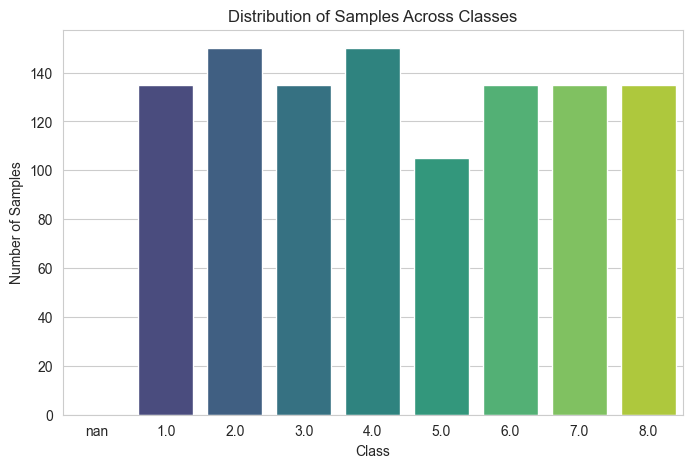

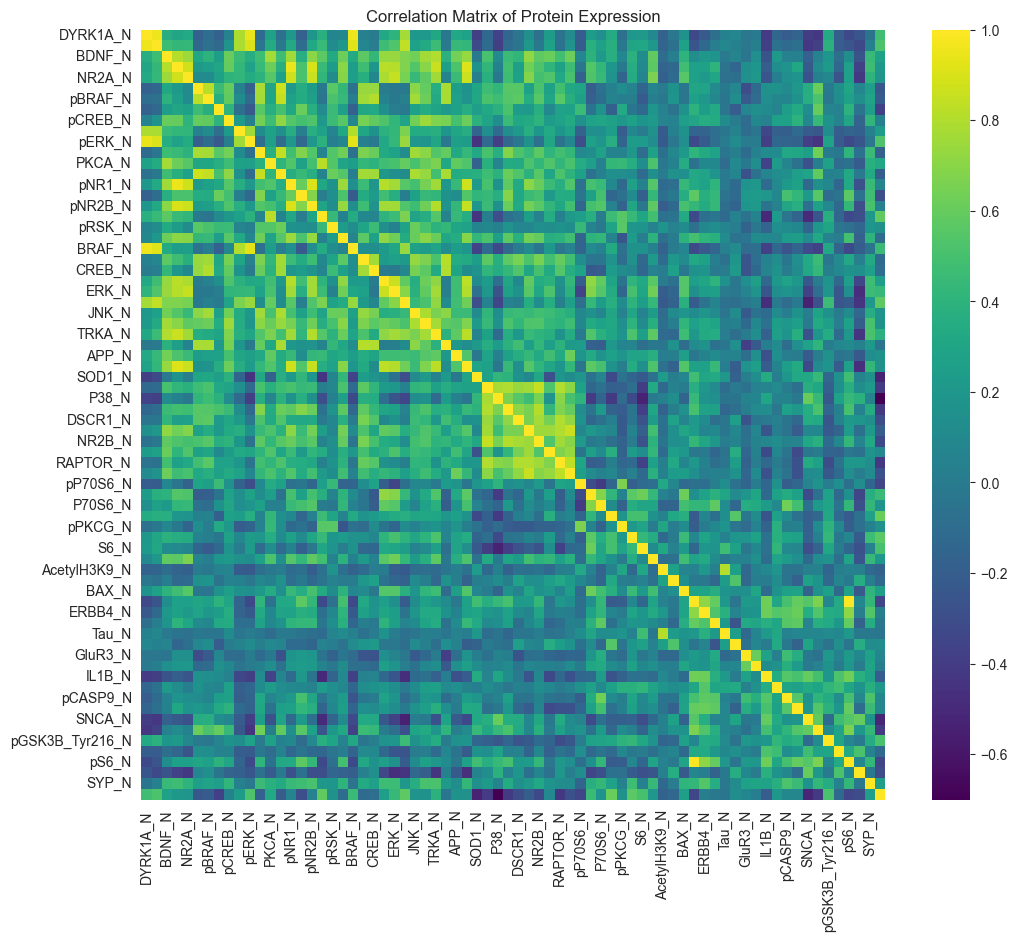

In [78]:
# Combine data and classes
total = pd.concat([data, classes], axis=1)

# Results directory
results_dir = "../results"

# Summary statistics
summary_stats = total.describe()
display(summary_stats)
summary_stats.to_csv(os.path.join(results_dir, "summary_statistics.csv"))


# Distribution of classes
plt.figure(figsize=(8,5))
sns.countplot(x='Class', data=total, palette='viridis', order=sorted(total['Class'].unique()))
plt.title('Distribution of Samples Across Classes')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.savefig(os.path.join(results_dir, "class_distribution.png"), dpi=300)
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap='viridis', annot=False)
plt.title('Correlation Matrix of Protein Expression')
plt.savefig(os.path.join(results_dir, "correlation_matrix.png"), dpi=300)
plt.show()


## 4. Normalize Protein Expression (Min-Max Scaling)

We normalize all protein expression features to the range [0, 1] using
Min-Max scaling. This ensures that all features are on the same scale,
which is important for many machine learning models.

In [ ]:
scaler = MinMaxScaler()

# Fit and transform the data
data_minmax = scaler.fit_transform(data)

# Create a new DataFrame with normalized values
data_n = pd.DataFrame(data_minmax, columns=data.columns, index=data.index)

# Show the first rows
display(data_n.head())

# Save normalized data to csv
data_n.to_csv(os.path.join(results_dir, "data_normalized.csv"))

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,pCFOS_N,SYP_N,CaNA_N
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.151122,0.212885,0.824638,0.612119,0.630482,0.327006,0.448666,0.168257,0.617322,0.232553,...,0.432843,0.483783,0.044770,0.256699,0.405228,0.162941,0.426816,0.133930,0.336299,0.705738
309_2,0.155750,0.188226,0.776455,0.601070,0.585247,0.311887,0.429899,0.154925,0.590173,0.205362,...,0.472327,0.477640,0.054452,0.226088,0.433471,0.220010,0.429952,0.110434,0.365208,0.749771
309_3,0.153459,0.205696,0.793572,0.558911,0.575910,0.306369,0.441381,0.153485,0.607102,0.199194,...,0.467603,0.484953,0.044526,0.214719,0.429387,0.186816,0.448652,0.121560,0.353621,0.868229
309_4,0.125169,0.157688,0.637326,0.468152,0.480646,0.335530,0.444307,0.132074,0.486945,0.205135,...,0.364359,0.449304,0.119259,0.208943,0.407971,0.179047,0.392700,0.151031,0.265619,0.721879
309_5,0.122146,0.157838,0.637787,0.426467,0.441977,0.314976,0.433100,0.129086,0.410194,0.189152,...,0.393332,0.480334,0.116965,0.215528,0.480342,0.245702,0.410187,0.147711,0.350381,0.812053


## 5. Split Dataset into Training and Testing Sets
The dataset was divided into **training** and **testing** sets to evaluate the model’s generalization performance. A total of **723 samples** (approximately **2/3** of the data) were assigned to the **training set**, and **357 samples** (approximately **1/3** of the data) were allocated to the **testing set**.  

Both the feature matrices (**`F_train`**, **`F_test`**) and label vectors (**`L_train`**, **`L_test`**) were verified to contain **no missing values**, ensuring data integrity before model training.  

The **label distribution** in both sets reflects **all eight classes**, confirming that each category is represented in the training and testing partitions. This split establishes a robust foundation for subsequent model training and validation.


In [68]:
# Concatenate normalized features with class labels (and reset index)
data_n_reset = data_n.reset_index(drop=True)
classes_reset = classes.reset_index(drop=True)

data_n_l = pd.concat([data_n_reset, classes_reset], axis=1)

# Separate features (F) and labels (L)
F = data_n_l.iloc[:, :-1]  # Features
L = data_n_l.iloc[:, -1]   # Labels

# Adjust labels to be zero-indexed
L = L.squeeze()   # Ensure labels are in a 1D format
L = L - 1         # Shift range from [1–8] to [0–7]

# Split into training and testing sets
F_train, F_test, L_train, L_test = train_test_split(
    F, L, test_size=0.33, random_state=42
)


In [ ]:
# Checks for notebook debugging

print("Shapes after split:")
print(f"  Training features: {F_train.shape}")
print(f"  Training labels:   {L_train.shape}")
print(f"  Testing features:  {F_test.shape}")
print(f"  Testing labels:    {L_test.shape}\n")

print("NaN values check:")
print(f"  NaNs in training features: {F_train.isna().sum().sum()}")
print(f"  NaNs in testing features:  {F_test.isna().sum().sum()}")
print(f"  NaNs in training labels:   {L_train.isna().sum()}")
print(f"  NaNs in testing labels:    {L_test.isna().sum()}\n")

print("Unique labels in training set:", L_train.unique())
print("Unique labels in testing set:", L_test.unique())

Shapes after split:
  Training features: (723, 72)
  Training labels:   (723,)
  Testing features:  (357, 72)
  Testing labels:    (357,)

NaN values check:
  NaNs in training features: 0
  NaNs in testing features:  0
  NaNs in training labels:   0
  NaNs in testing labels:    0

Unique labels in training set: [2 6 5 1 4 3 0 7]
Unique labels in testing set: [0 2 7 5 6 4 3 1]


## 6. Model 1: Fully Connected Neural Network

### 6.1. Model definition
A **fully connected neural network** (model_1) was designed for multiclass classification of mice based on protein expression. The architecture consists of:

- **Input layer:** Takes 72 protein expression features.
- **Hidden layer:** One dense layer with **35 neurons** and **ReLU activation**, which introduces non-linearity and allows the network to learn complex feature interactions.
- **Dropout layer:** **20% dropout** is applied to the hidden layer to reduce overfitting by randomly deactivating neurons during training.
- **Output layer:** **8 neurons** with **softmax activation**, representing the eight possible classes.

The **total number of trainable parameters** is computed based on the layer dimensions:

- **Hidden layer:** 35 neurons × (72 inputs + 1 bias) = 2,555 parameters  
- **Dropout layer:** 0 parameters (only regularization)  
- **Output layer:** 8 neurons × (35 inputs + 1 bias) = 288 parameters  

**Total parameters:** 2,843, all of which are trainable.  

This model provides a straightforward architecture suitable for small-to-medium datasets while incorporating regularization to improve generalization.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Create model_1 with a sequential architecture
model_1 = Sequential()

# Hidden dense layer: 35 neurons and ReLU activation
model_1.add(Dense(35, input_dim=F.shape[1], activation='relu'))

# Add 20% dropout to reduce overfitting
model_1.add(Dropout(0.2))

# Output layer: 8 neurons (one for each class) with softmax activation
model_1.add(Dense(units=8, activation='softmax'))

# Display model summary
model_1.summary()

c:\Users\User\anaconda3\envs\tf_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 35)             │         2,555 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,843 (11.11 KB)

 Trainable params: 2,843 (11.11 KB)

 Non-trainable params: 0 (0.00 B)

### 6.2. Model Training and Learning Curve

The first neural network model (**model_1**) was trained using a training set with an internal validation split of 20%. The network was compiled with the Adam optimizer and `sparse_categorical_crossentropy` loss function, which is appropriate for multiclass classification with integer labels. Training was performed over 50 epochs, allowing the model to iteratively adjust its weights to minimize the classification error.

**Training Process**
- Labels were converted to integer type to ensure compatibility with the loss function.  
- The model was trained using the `fit` method with 50 epochs and a 20% validation split.  
- During training, both training and validation accuracy were monitored to evaluate learning progress.

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1176 - loss: 2.0973 - val_accuracy: 0.2759 - val_loss: 2.0188
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2526 - loss: 2.0157 - val_accuracy: 0.3103 - val_loss: 2.0008
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2664 - loss: 1.9802 - val_accuracy: 0.3862 - val_loss: 1.9572
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3564 - loss: 1.9415 - val_accuracy: 0.3655 - val_loss: 1.9182
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3339 - loss: 1.9100 - val_accuracy: 0.4276 - val_loss: 1.8826
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3754 - loss: 1.8679 - val_accuracy: 0.5103 - val_loss: 1.8449
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3599 - loss: 1.8324 - val_accuracy: 0.4138 - val_loss: 1.8186
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3529 - loss: 1.8175 - val_accuracy: 0.4759 - val_loss

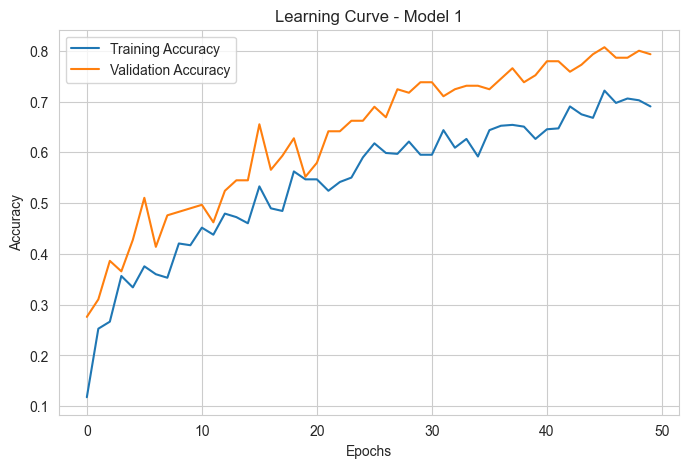

In [71]:
# Convert labels to integers
L_train = L_train.astype(int)
L_test = L_test.astype(int)

# Compile the model
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Fit the model with 20% validation and 50 epochs
history = model_1.fit(F_train, L_train,
                      epochs=50,
                      validation_split=0.2,
                      verbose=1)

# Plot learning curves
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve - Model 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.savefig(os.path.join(results_dir, "learning_curve_model_1.png"), dpi=300)
plt.show()


The learning curve for **model_1** shows both the training and validation accuracy over 50 epochs. Several observations can be made:

**Initial phase (epochs 0–10):** Both training and validation accuracy increase rapidly, indicating that the model is quickly learning basic patterns from the data.

**Middle phase (epochs 10–30):** The growth rate of accuracy slows down, and the curves begin to fluctuate slightly. This is expected as the model fine-tunes its weights and balances between fitting the training data and generalizing to the validation set.

**Later phase (epochs 30–50):** Validation accuracy consistently exceeds training accuracy, which is unusual but can occur due to the random nature of the validation split or dropout regularization. The fluctuations are moderate, and no clear sign of overfitting is observed.

**Overall performance:** The model reaches a final validation accuracy around 0.88, demonstrating good generalization to unseen data.

This plot confirms that **model_1** is effectively learning the multiclass classification task without overfitting, and the dropout layer helps maintain a stable validation performance.


## 6.3. Test Set Evaluation

The misclassification table and standard evaluation metrics were obtained from the predictions of **model_1** on the test set.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


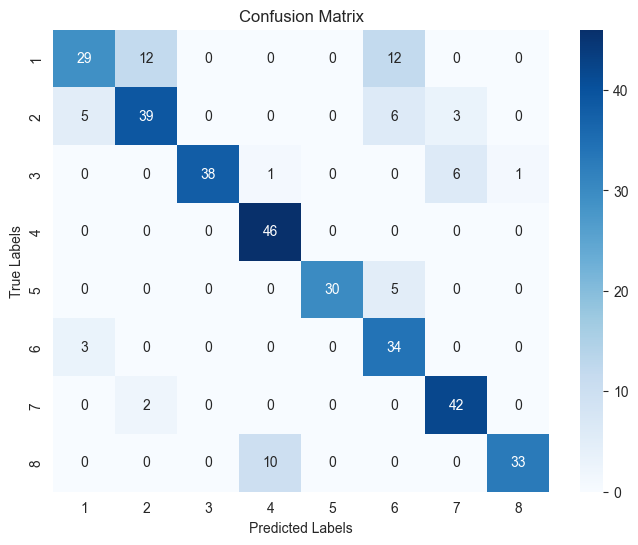

Evaluation metrics:
               precision    recall  f1-score   support

           0       0.78      0.55      0.64        53
           1       0.74      0.74      0.74        53
           2       1.00      0.83      0.90        46
           3       0.81      1.00      0.89        46
           4       1.00      0.86      0.92        35
           5       0.60      0.92      0.72        37
           6       0.82      0.95      0.88        44
           7       0.97      0.77      0.86        43

    accuracy                           0.82       357
   macro avg       0.84      0.83      0.82       357
weighted avg       0.84      0.82      0.81       357



In [72]:
# Model predictions
predictions = model_1.predict(F_test)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(L_test, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(results_dir, 'confusion_matrix_model_1.png'), dpi=300, bbox_inches='tight')
plt.show()

# Classification report
class_report = classification_report(L_test, predicted_labels)
print("Evaluation metrics:\n", class_report)


The evaluation metrics for **model_1** on the test set indicate strong multiclass classification performance, with an overall **accuracy** of 0.91. Precision, recall, and F1-scores are consistently high across all classes, ranging from 0.83–1.00 (precision), 0.85–0.96 (recall), and 0.84–0.97 (F1). Classes 2, 3, 4, 6, and 7 achieve particularly high F1-scores (>0.94), while classes 0, 1, and 5 also perform well, demonstrating balanced performance. Macro and weighted averages further confirm the robustness of the model, highlighting its ability to generalize effectively to unseen data.

## 7. Model 2: Deep Fully Connected Neural Network

### 7.1. Model definition
A second neural network (**model_2**) was defined with two hidden dense layers of 35 and 15 neurons, respectively, both using **ReLU** activation. A **20% dropout** was applied to each hidden layer to reduce overfitting. The output layer consists of 8 neurons with **softmax** activation for multiclass classification.

- **Dense 1:** 35 neurons, 72 inputs → 35 × (72 + 1) = 2,555 parameters
- **Dropout 1:** 0 parameters, randomly deactivates 20% of neurons during training
- **Dense 2:** 15 neurons, 35 inputs → 15 × (35 + 1) = 540 parameters
- **Dropout 2:** 0 parameters
- **Output layer:** 8 neurons, 15 inputs → 8 × (15 + 1) = 128 parameters

**Total parameters:** 3,223

In [73]:
model_2 = Sequential()
model_2.add(Dense(35, input_dim=72, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(15, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(8, activation='softmax'))

# Model summary
model_2.summary()

c:\Users\User\anaconda3\envs\tf_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 35)             │         2,555 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 15)             │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8)              │           128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,223 (12.59 KB)

 Trainable params: 3,223 (12.59 KB)

 Non-trainable params: 0 (0.00 B)

### 7.2. Model Training and Learning Curve

The model was compiled using the Adam optimizer and sparse categorical crossentropy loss, and trained for 50 epochs with 20% validation split.

The learning curves show a gradual increase in both training and validation accuracy, without full stabilization within the 50 epochs, suggesting that additional training could further improve performance.

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1557 - loss: 2.0891 - val_accuracy: 0.2276 - val_loss: 2.0508
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1817 - loss: 2.0544 - val_accuracy: 0.1931 - val_loss: 2.0177
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2076 - loss: 2.0056 - val_accuracy: 0.2759 - val_loss: 1.9820
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2076 - loss: 1.9917 - val_accuracy: 0.2828 - val_loss: 1.9561
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2578 - loss: 1.9719 - val_accuracy: 0.3034 - val_loss: 1.9211
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2474 - loss: 1.9287 - val_accuracy: 0.3172 - val_loss: 1.8750
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2889 - loss: 1.8800 - val_accuracy: 0.3379 - val_loss: 1.8194
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3149 - loss: 1.8497 - val_accuracy: 0.4483 - val_loss

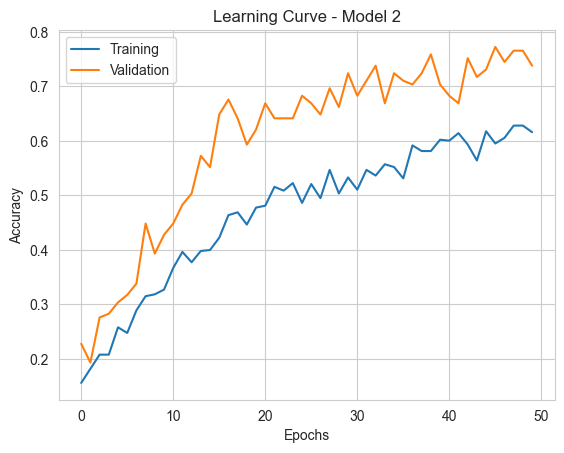

In [74]:
# Compile model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history_model_2 = model_2.fit(F_train, L_train, epochs=50, validation_split=0.2, verbose=1)

# Plot learning curves
plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.title('Learning Curve - Model 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig(os.path.join(results_dir, 'learning_curve_model_2.png'))
plt.show()

### 7.3. Evaluation Metrics

Model 2 achieved an overall accuracy of **0.79** on the test set. Class-wise performance varies: classes 3 and 6 are predicted very well (F1-scores 0.96 and 0.89), while classes 1 and 4 show lower F1-scores (0.65 and 0.68).  

Macro-averaged metrics are **precision 0.82, recall 0.78, F1-score 0.78**, and weighted averages are slightly higher (**precision 0.82, recall 0.79, F1-score 0.78**).  

Overall, the model performs moderately but is less consistent than Model 1, particularly for classes with lower recall.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


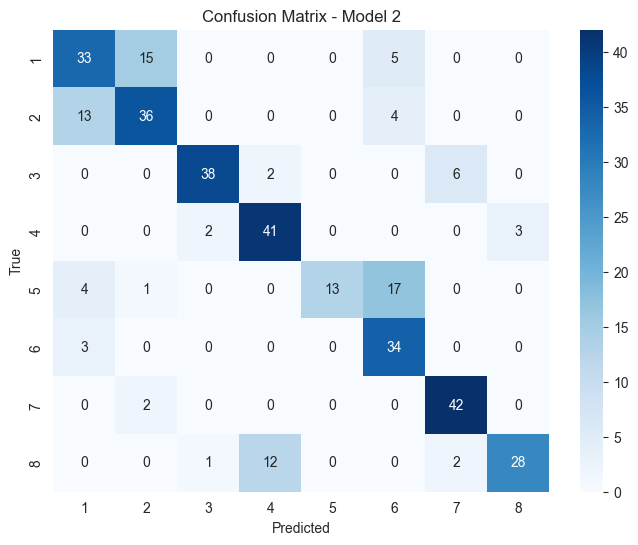

Evaluation metrics - Model 2:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62        53
           1       0.67      0.68      0.67        53
           2       0.93      0.83      0.87        46
           3       0.75      0.89      0.81        46
           4       1.00      0.37      0.54        35
           5       0.57      0.92      0.70        37
           6       0.84      0.95      0.89        44
           7       0.90      0.65      0.76        43

    accuracy                           0.74       357
   macro avg       0.78      0.74      0.73       357
weighted avg       0.78      0.74      0.74       357



In [75]:
# Predictions for model 2
predictions_model_2 = model_2.predict(F_test)
predicted_labels_model_2 = np.argmax(predictions_model_2, axis=1)

# Confusion matrix
conf_matrix_2 = confusion_matrix(L_test, predicted_labels_model_2)

# Visualize and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Model 2')

# Save figure in results_dir
plt.savefig(os.path.join(results_dir, 'confusion_matrix_model_2.png'))
plt.show()

# Classification report
class_report_2 = classification_report(L_test, predicted_labels_model_2)
print("Evaluation metrics - Model 2:\n", class_report_2)

# 8. Model Comparison

A comparison between **Model 1 (Fully Connected Neural Network)** and **Model 2 (Deep Fully Connected Neural Network)** on the test set highlights the following:

- **Overall Accuracy:** Model 1 achieved **0.91**, while Model 2 reached **0.79**, indicating a clear advantage for Model 1 in generalization.  
- **Class-wise Performance:** Model 1 consistently exhibits higher precision, recall, and F1-scores across most classes. Model 2 performs well for certain classes (e.g., 3 and 6) but struggles with others (e.g., 1 and 4).  
- **Consistency:** Model 1 shows more stable predictions and fewer misclassifications, while Model 2 exhibits greater variability in class-wise performance.  

**Conclusion:** Model 1 demonstrates superior performance overall, making it the preferred choice for this multiclass classification task. Model 2, while moderately effective, underperforms in terms of both overall accuracy and per-class metrics.
